In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

import math

sim = Aer.get_backend('qasm_simulator')

# using tikzplotlib to export plot to latex
import tikzplotlib

def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

def save_fig(name, width='10cm', height='10cm'):
    fig = plt.gcf()
    tikzplotlib_fix_ncols(fig)

    tikzplotlib.clean_figure()
    tikzplotlib.save(name + '.tex', axis_width=width, axis_height=height)

In [2]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [3]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

In [4]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

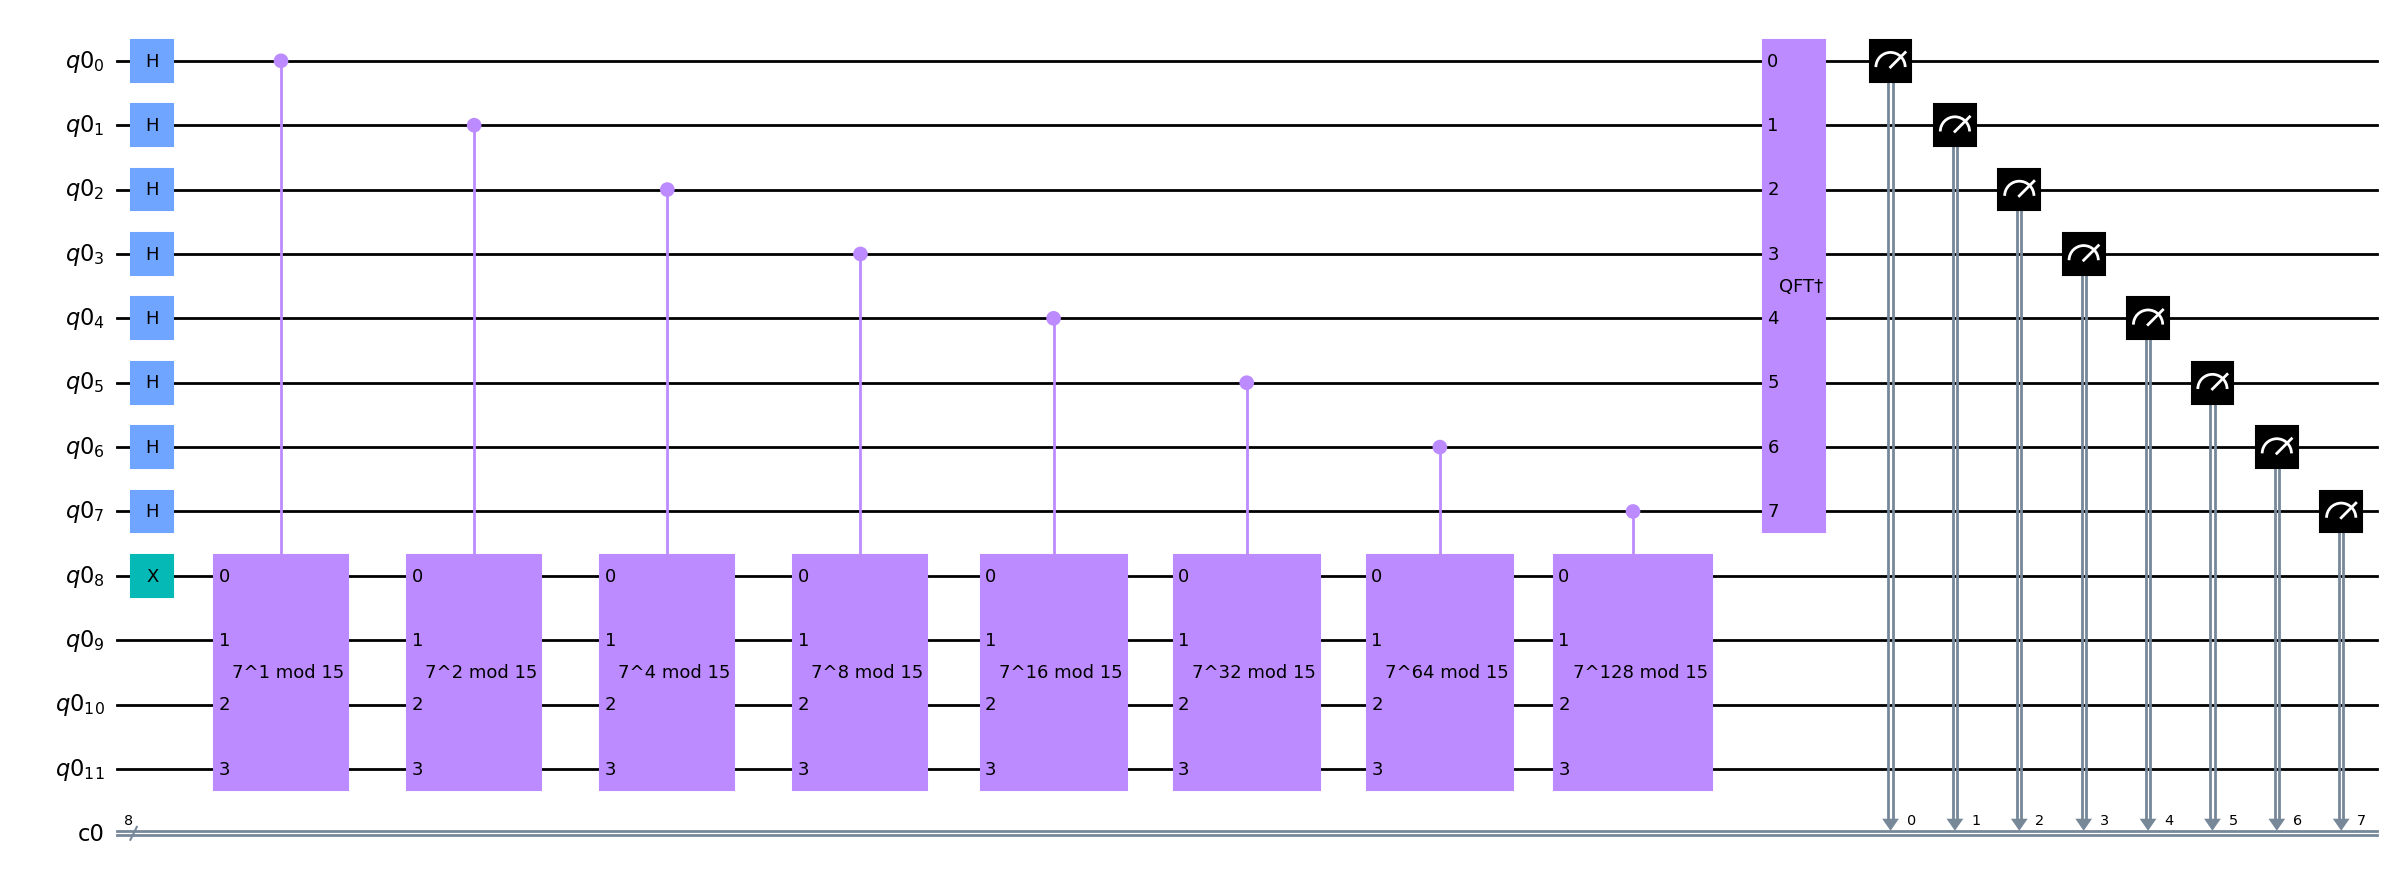

In [5]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qr = QuantumRegister(N_COUNT + 4)
cr = ClassicalRegister(N_COUNT)
qc = QuantumCircuit(qr, cr)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
              [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1, output='mpl')  # -1 means 'do not fold'

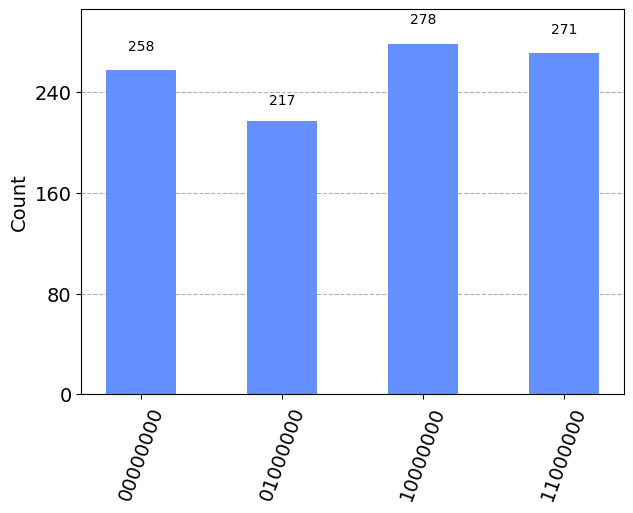

In [6]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [7]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  10000000(bin) = 128(dec)  128/256 = 0.50
1  00000000(bin) =   0(dec)    0/256 = 0.00
2  11000000(bin) = 192(dec)  192/256 = 0.75
3  01000000(bin) =  64(dec)   64/256 = 0.25


In [8]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.50      1/2            2
1   0.00      0/1            1
2   0.75      3/4            4
3   0.25      1/4            4


In [9]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.fake_provider import FakeMelbourne
backend = FakeMelbourne()
shots=1024

Start...
Done... (1/?)
Done... (2/?)


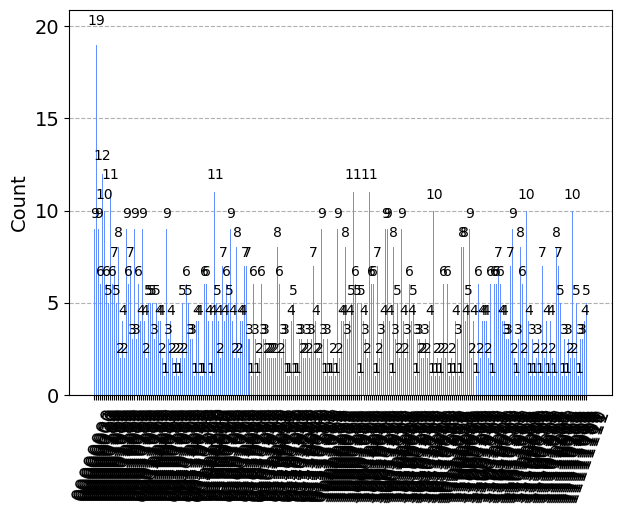

In [10]:
print('Start...')
qc_trans = transpile(qc, backend, optimization_level=1)
print('Done... (1/?)')
results = execute(qc_trans, backend, shots=shots).result()
print('Done... (2/?)')
counts_re = results.get_counts()
plot_histogram(counts_re)

In [11]:
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2,3,4,5,6,7], circlabel='mcal')

In [12]:
job = execute(meas_calibs, backend=backend, shots=shots)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

In [13]:
meas_filter = meas_fitter.filter

mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

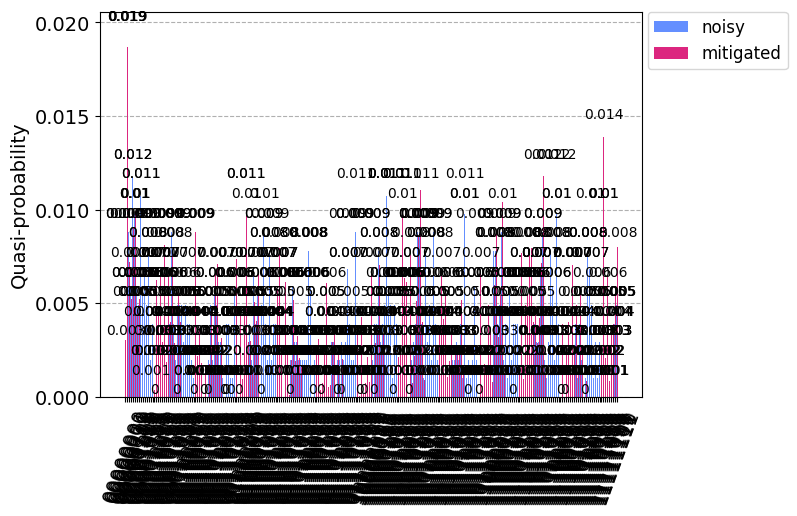

In [14]:
plot_histogram([counts_re, mitigated_counts], legend=['noisy', 'mitigated'])

In [15]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools import job_monitor
from qiskit_ibm_runtime import QiskitRuntimeService

shots = 8192
provider = IBMQ.load_account()

service = QiskitRuntimeService()

C:\Users\romai\AppData\Local\Temp\ipykernel_28196\2450165869.py:7: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


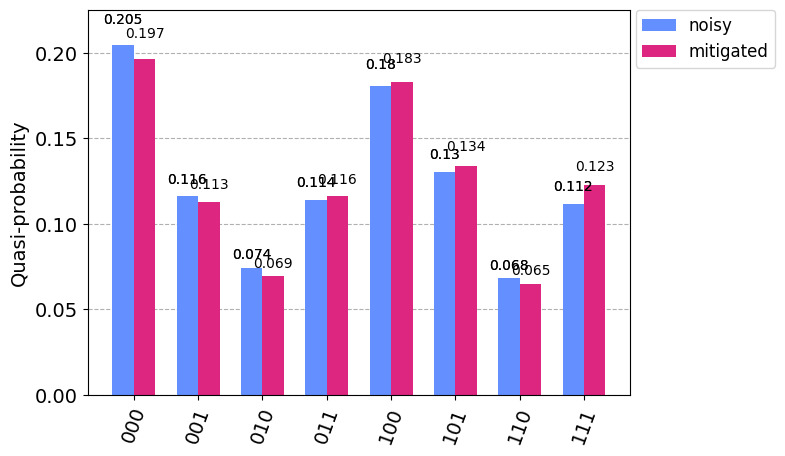

In [16]:
# Specify variables
N_COUNT = 3  # number of counting qubits
a = 7

# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qr = QuantumRegister(N_COUNT + 4)
cr = ClassicalRegister(N_COUNT)
qc = QuantumCircuit(qr, cr)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
              [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))

qc.draw(output='mpl')

from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], circlabel='mcal')

# device = least_busy(
#     provider.backends(
#         filters=lambda x: x.configuration().n_qubits >= 7
#                           and not x.configuration().simulator                # Not a simulator
#                           and x.status().operational == True                 # Operational backend
#     )
# )
#
# display(device)
#
# Submit a job.
# jobcal = execute(meas_calibs, backend=device)
# job_monitor(jobcal)
# job = execute(qc, backend=device, optimization_level=3, shots=shots)
# job_monitor(job)

# Executé le 31.08.2023 sur ibm_nairobi
jobcal = service.job('cjo1ngpdll3gjfa1lne0')
job = service.job('cjo1svhpthn588jkkphg')

count = job.result().get_counts()
meas_cal = jobcal.result()

meas_fitter = CompleteMeasFitter(meas_cal, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter

mitigated_results = meas_filter.apply(job.result())
mitigated_counts = mitigated_results.get_counts()

plot_histogram([count, mitigated_counts], legend=['noisy', 'mitigated'])